<a href="https://colab.research.google.com/github/arminwitte/llsi/blob/main/notebooks/example.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import sys
import os

# Install llsi if running in Google Colab
if "google.colab" in sys.modules:
    !pip install llsi


In [45]:
import os
import urllib.request

# Check if data exists locally (repo structure), otherwise download
local_path = "../data/heated_wire_data.npy"
filename = "heated_wire_data.npy"

if os.path.exists(local_path):
    data_path = local_path
    print(f"Using local data from {data_path}")
elif os.path.exists(filename):
    data_path = filename
    print(f"Using existing {filename}")
else:
    print("Downloading data...")
    url = "https://raw.githubusercontent.com/arminwitte/llsi/main/data/heated_wire_data.npy"
    urllib.request.urlretrieve(url, filename)
    data_path = filename


Using local data from ../data/heated_wire_data.npy


In [46]:
import numpy as np

import llsi

d = np.load("../data/heated_wire_data.npy")



In [47]:
t = d[:, 0]
Re = d[:, 1]
Nu = d[:, 2]

In [48]:
data = llsi.SysIdData(t=t, Re=Re, Nu=Nu)
data.equidistant()
data.center()
data.downsample(30)
data, test_set = data.split(0.8)
data.lowpass(1, 10)
data.crop(start=1000)
data.center()
test_set.center()

In [69]:
models = []
combinations = [
    ("po-moesp", (1,),{"enforce_stability": True}),
    ("n4sid", (3,) , {"lambda": 1e-6, "enforce_stability": True}),
    ("arx", (2,2,0), ),
    ("fir", (200,0), {"lambda": 1e0}),
    ("firor", 2, {"lambda": 1e0}, {"fir_order": 200, "lambda": 1e-6}),
    ("oe", (3,3,0)),
    ("pem", (3,3,0), {"init_method": "po-moesp", "init_order": 3}),
    ("pem", (3,3,0), {"init_method": "n4sid", "init_order": 3})]



for i in range(len(combinations)):
    method = combinations[i][0]
    print(f"Identifying model {i + 1} using method '{method}'")
    order = combinations[i][1]
    settings = combinations[i][2] if len(combinations[i]) > 2 else {}
    model = llsi.sysid(data, "Nu", "Re", order, method=method, settings=settings)
    models.append(model)

Identifying model 1 using method 'po-moesp'
Identifying model 2 using method 'n4sid'
Identifying model 3 using method 'arx'
Identifying model 4 using method 'fir'
Identifying model 5 using method 'firor'
Identifying model 6 using method 'oe'
Identifying model 7 using method 'pem'
Identifying model 8 using method 'pem'


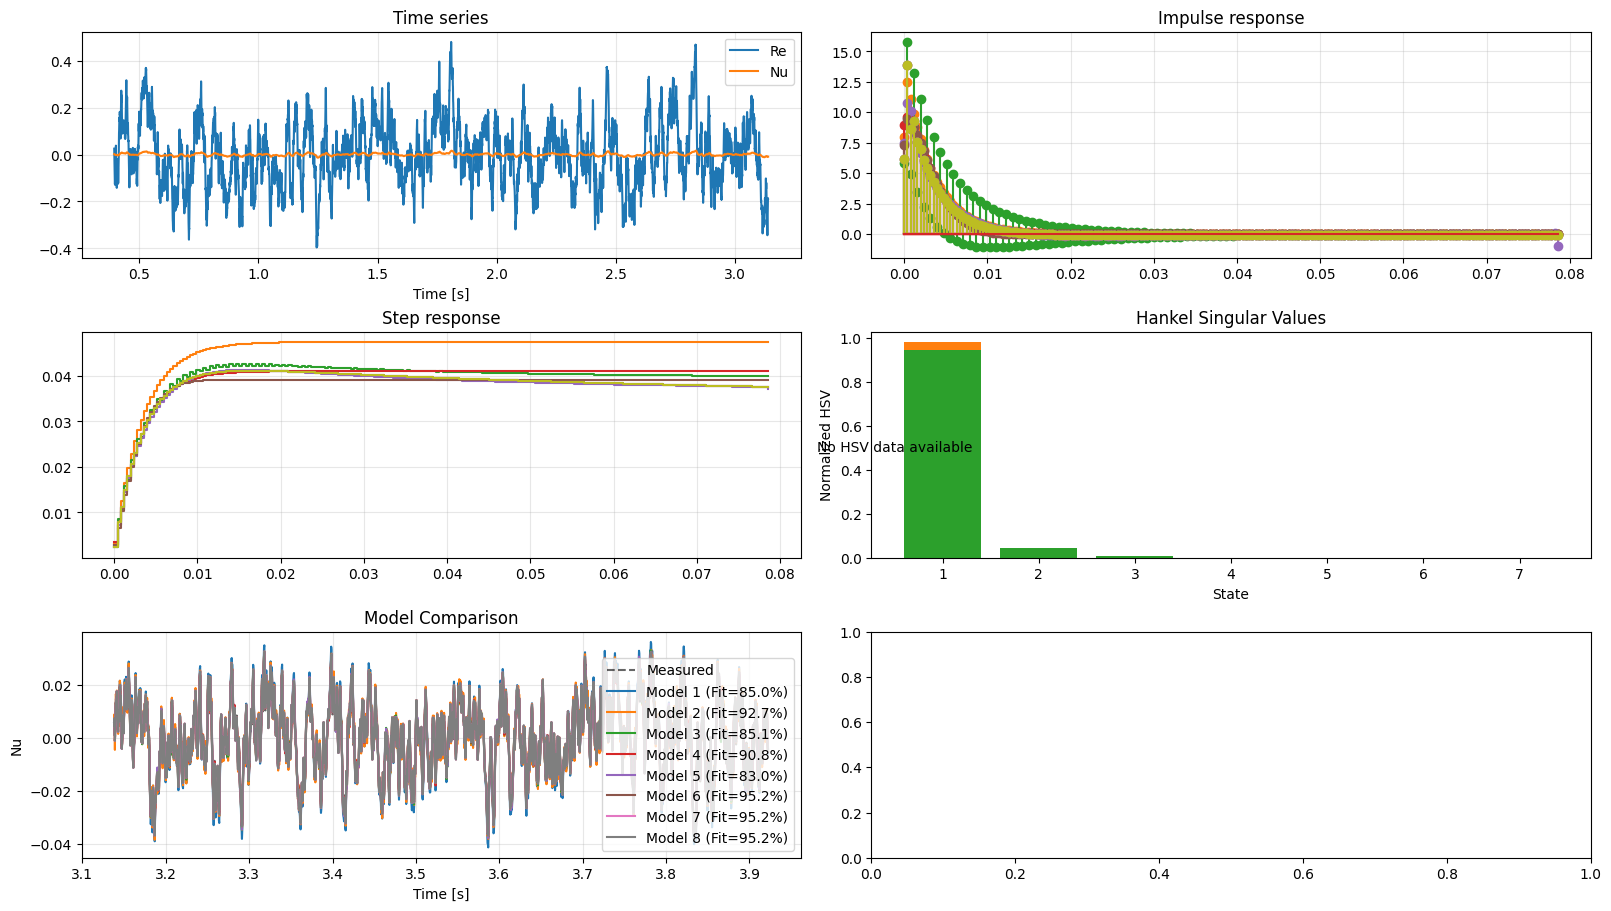

In [70]:
with llsi.Figure() as fig:
    fig.plot(data)
    fig.plot(models, "impulse")
    fig.plot(models, "step")
    fig.plot(models, "hsv")
    fig.plot(
        {"mod": models, "data": test_set, "y_name": "Nu", "u_name": "Re"},
        "compare",
    )